# Runtime estimates for each distance

Computation performed on a MacBook Pro (16-inch, 2019) with a 2.6 GHz 6-Core Intel Core i7 processor, 16 GB 2667 MHz DDR4 memory, AMD Radeon Pro 5300M 4 GB graphics card, running Monterey (Version 12.6.7).

In [1]:
import os
os.chdir('..')

In [33]:
import time
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pertpy as pt

from utils import plt_legend

sc.set_figure_params(dpi=100, frameon=False, facecolor=None, transparent=True, ipython_format='svg', vector_friendly=False)
plt.rcParams['svg.fonttype'] = 'none'

/home/icb/yuge.ji/miniconda3/envs/pertpy_clean2/lib/python3.10/site-packages/scanpy/_settings.py:450: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [3]:
def plot(durations, label):
    df = pd.DataFrame(durations)
    df.columns = ['metric', 'runtime (seconds)', label]

    plt.figure(figsize=(7, 4))
    sns.lineplot(data=df, x=label, y='runtime (seconds)', hue='metric')
    plt_legend()
    plt.grid(False)

Load in a small dataset.

In [4]:
adata = pt.dt.adamson_2016_pilot()

# preprocessing
sc.pp.log1p(adata)
adata.layers['lognorm'] = adata.X.A
adata

Output()

AnnData object with n_obs × n_vars = 5768 × 35635
    obs: 'perturbation', 'read count', 'UMI count', 'tissue_type', 'cell_line', 'cancer', 'disease', 'perturbation_type', 'celltype', 'organism', 'ncounts', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts'
    var: 'ensembl_id', 'ncounts', 'ncells'
    uns: 'log1p'
    layers: 'lognorm'

We have 8 conditions, each with a decent number of cells.

In [5]:
adata.obs.perturbation.value_counts()

perturbation
62(mod)_pBA581    1769
SPI1_pDS255        696
EP300_pDS268       632
SNAI1_pDS266       562
ZNF326_pDS262      557
BHLHE40_pDS258     553
CREB1_pDS269       506
DDIT3_pDS263       477
*                    6
Name: count, dtype: int64

List of the metrics evaluated.

In [29]:
metrics = ['euclidean', 'spearman_distance', 'mean_absolute_error']  # representative
metrics += ['r2_distance', 'pearson_distance', 'mse', 'cosine_distance']  # fast
metrics += ['edistance', 'sym_kldiv', 'mmd', 'ks_test', 't_test', 'wasserstein'] # slow
metrics += ['classifier_proba', 'kendalltau_distance']  # newly added

Now we will evaluate scaling. Some distances will increase in runtime as the number of cells increases, and some will not. We would expect all distances to scale linearly with the number of genes. Finally, some distances handle an abundance of groups better than others due to benefitting from speedups in `pairwise` calculation.

## scaling by number of cells

In [6]:
# use 2k genes as default
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adt = adata[:, adata.var['highly_variable']]

durations = []
for n_cells in range(100, 601, 50):
    
    sub1 = sc.pp.subsample(adt[adt.obs.perturbation == 'SPI1_pDS255'], n_obs=n_cells, copy=True, random_state=1)
    sub2 = sc.pp.subsample(adt[adt.obs.perturbation == 'EP300_pDS268'], n_obs=n_cells, copy=True, random_state=2)
    
    for metric in metrics:
        start_time = time.time()

        distance = pt.tl.Distance(metric=metric, layer_key='lognorm')
        res = distance(sub1.X, sub2.X)
    
        runtime = time.time() - start_time
        durations.append((metric, runtime, n_cells))
        start_time = time.time()

Text(0.5, 1.0, 'Runtime increase with increasing sample size')

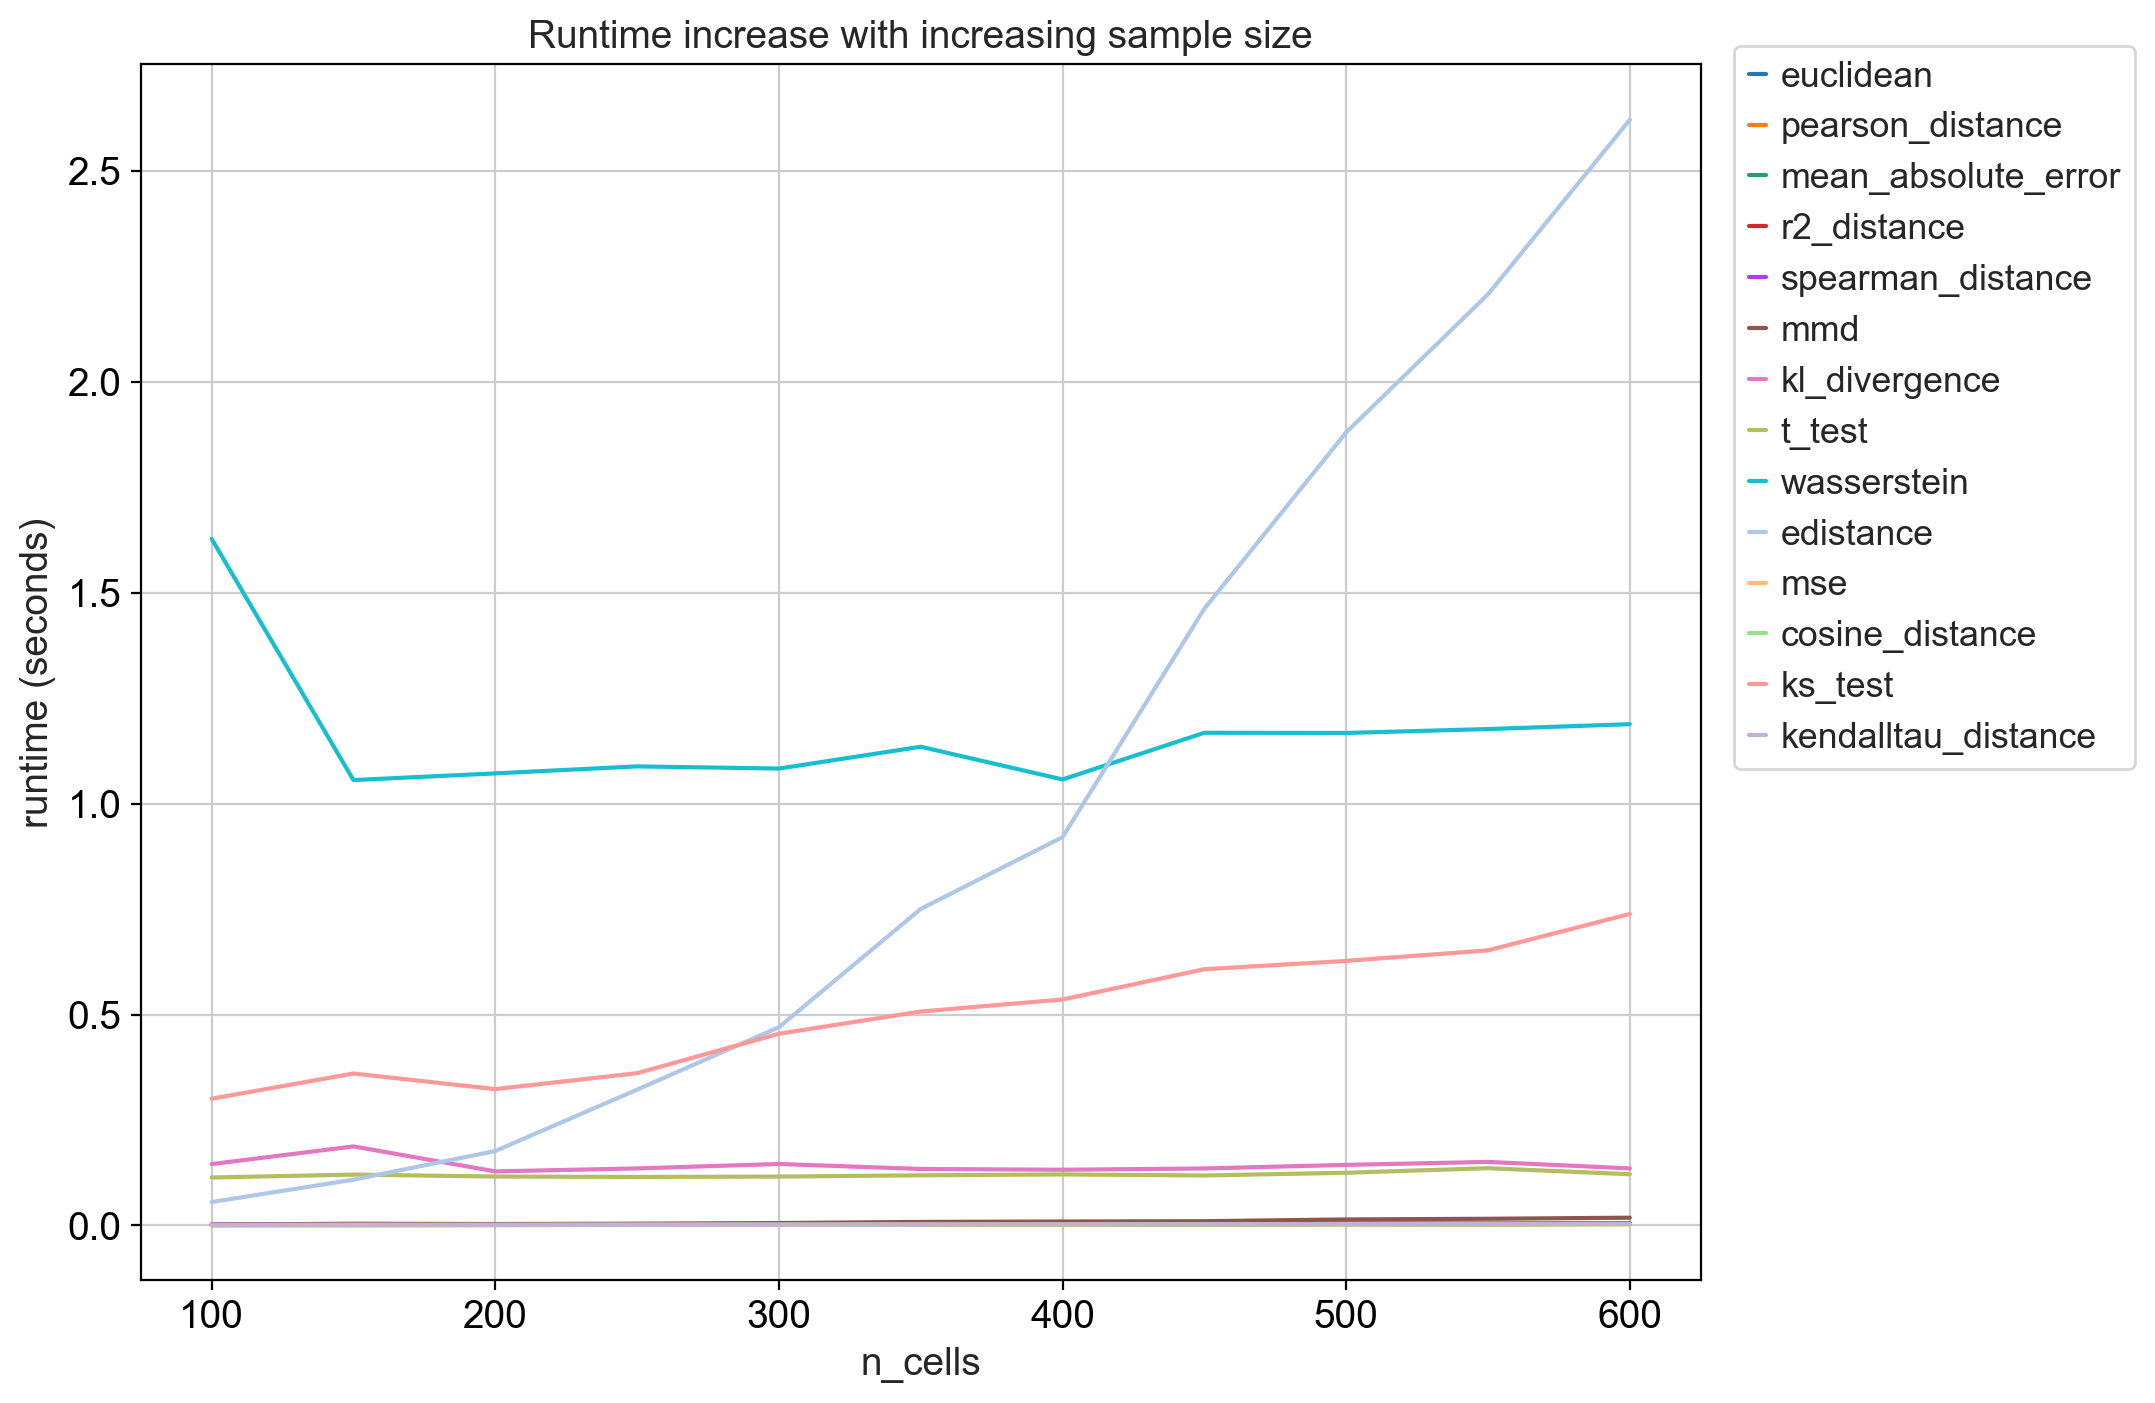

In [7]:
plot(durations, 'n_cells')
plt.title('Runtime increase with increasing sample size')

## scaling by number of genes

In [8]:
durations = []
for n_genes in range(1000, 10000, 1000):
    sc.pp.highly_variable_genes(adata, n_top_genes=n_genes)
    adt = adata[:, adata.var['highly_variable']]
    
    sub1 = sc.pp.subsample(adt[adt.obs.perturbation == 'SPI1_pDS255'], n_obs=300, copy=True, random_state=1)
    sub2 = sc.pp.subsample(adt[adt.obs.perturbation == 'EP300_pDS268'], n_obs=300, copy=True, random_state=2)
    
    for metric in metrics:
        start_time = time.time()

        distance = pt.tl.Distance(metric=metric, layer_key='lognorm')
        res = distance(sub1.X, sub2.X)
    
        runtime = time.time() - start_time
        durations.append((metric, runtime, n_genes))
        start_time = time.time()

Text(0.5, 1.0, 'Runtime increase with increasing number of features')

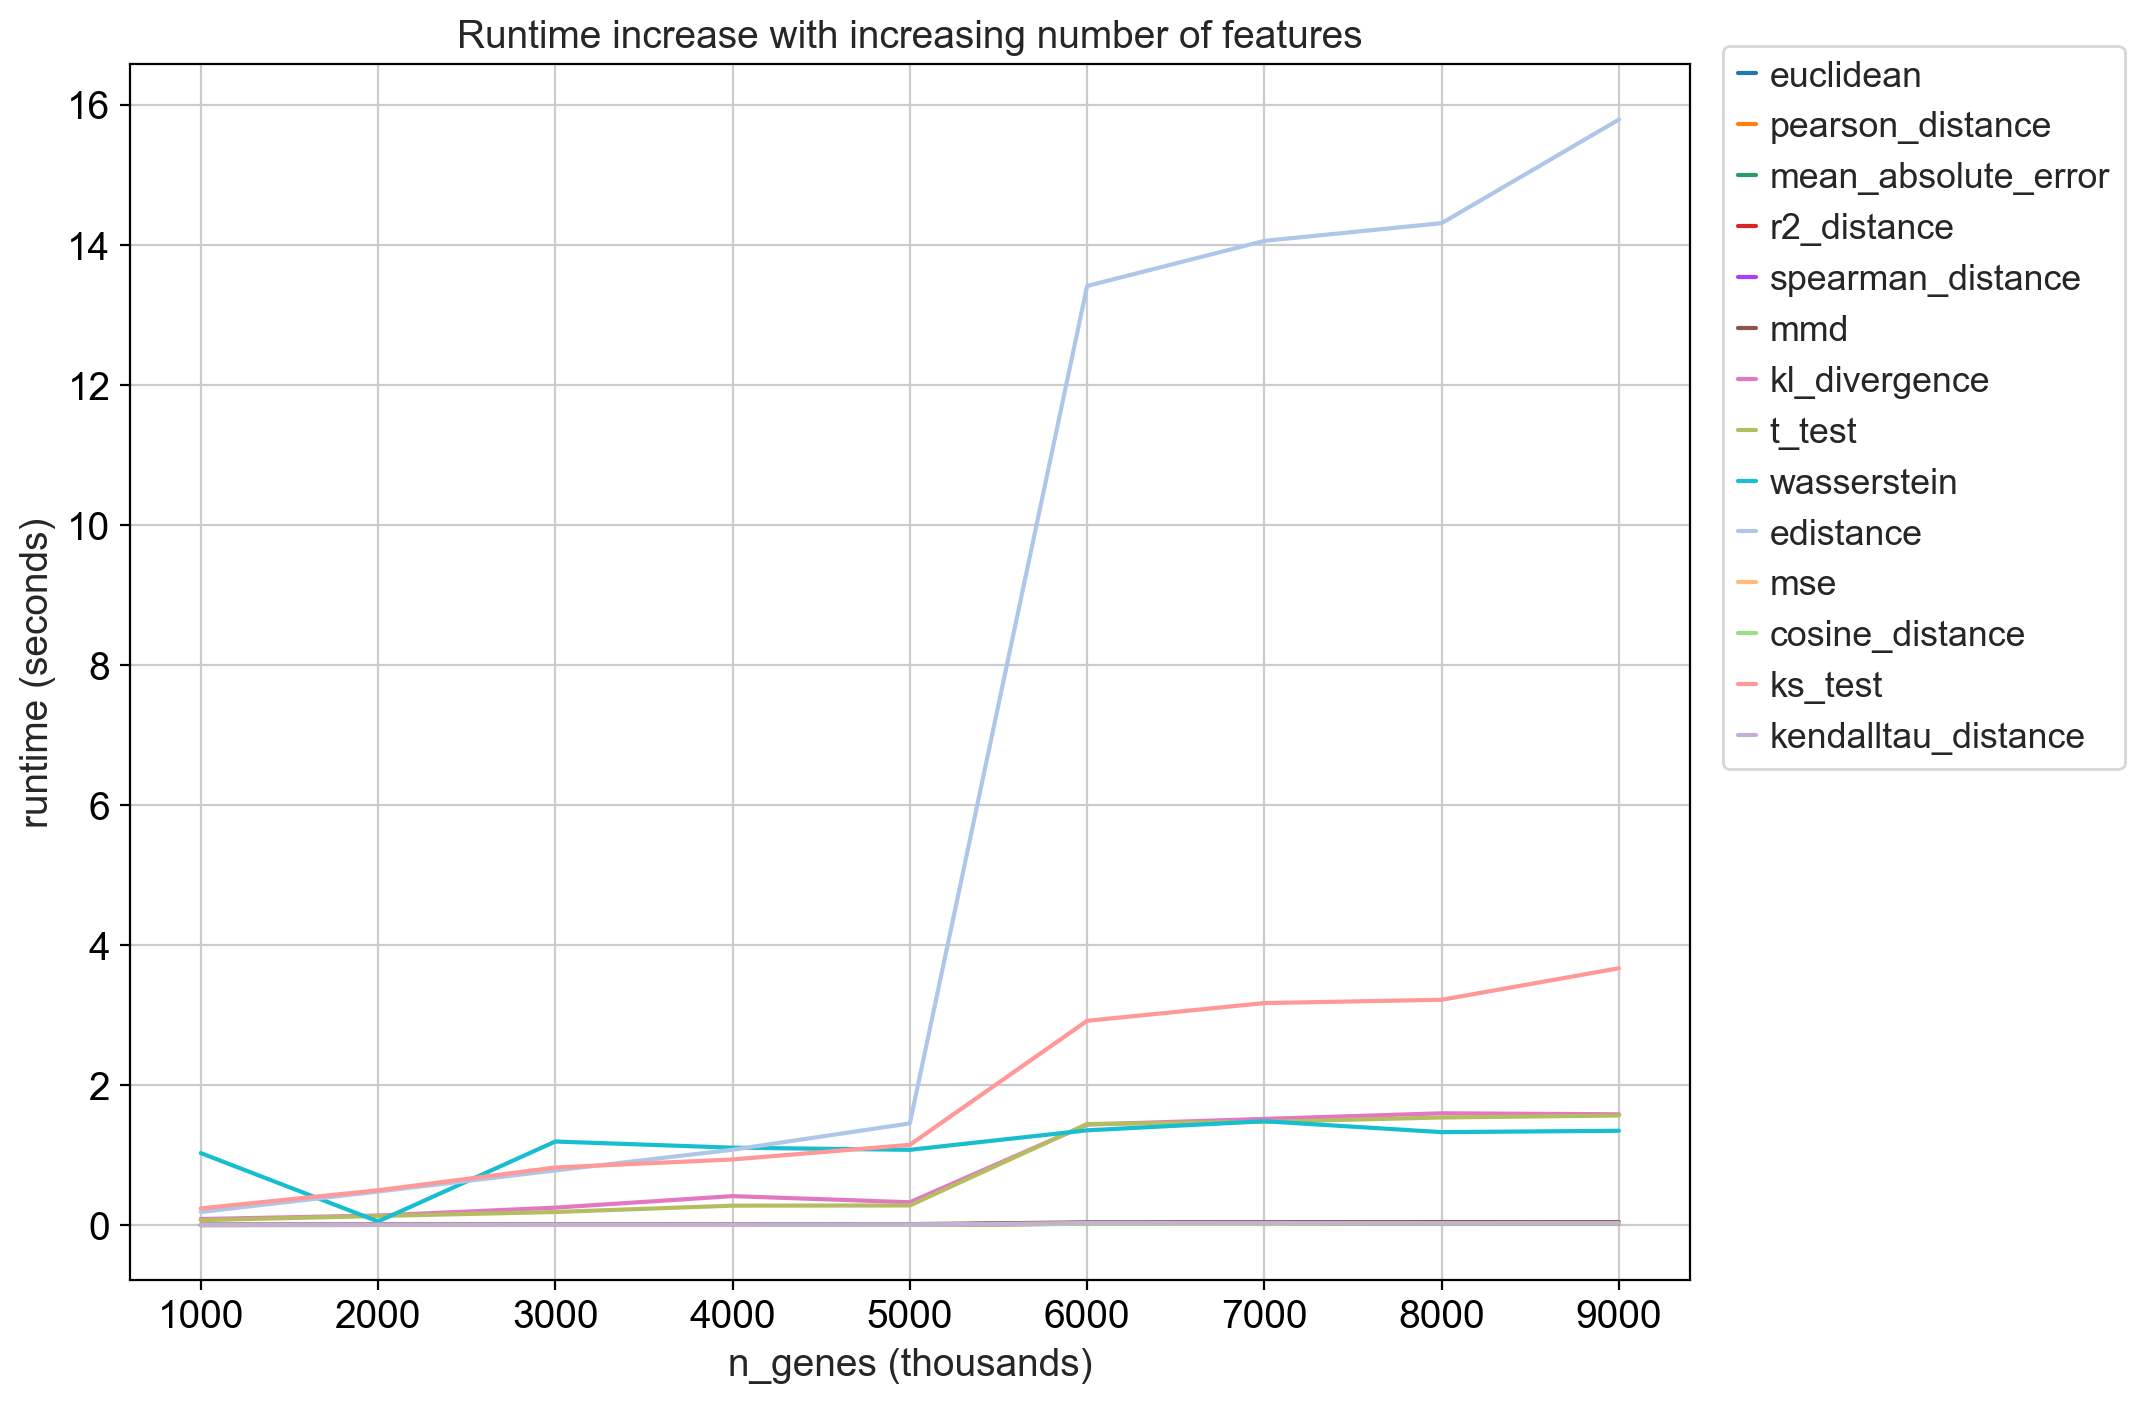

In [9]:
plot(durations, 'n_genes')
plt.title('Runtime increase with increasing number of features')

## scaling by number of categories

In [30]:
# use 2k genes as default
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adt = adata[:, adata.var['highly_variable']]

durations = []
for n_groups in range(2, 8):
    for metric in metrics:
        start_time = time.time()

        distance = pt.tl.Distance(metric=metric, layer_key='lognorm')
        groups = list(adata.obs.perturbation.value_counts().index[:n_groups])
        _ = distance.onesided_distances(adt, 'perturbation', selected_group='62(mod)_pBA581', groups=groups, show_progressbar=False)
#         res = distance.pairwise(adt, groupby='perturbation', groups=groups, show_progressbar=False)
    
        runtime = time.time() - start_time
        durations.append((metric, runtime, n_groups))
        start_time = time.time()

/home/icb/yuge.ji/miniconda3/envs/pertpy_clean2/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/home/icb/yuge.ji/pertpy/pertpy/tools/_distances/_distances.py:389: ImplicitModificationWarning: Setting element `.obsp['None_euclidean_predistances']` of view, initializing view as actual.
  adata.obsp[f"{self.obsm_key}_{self.cell_wise_metric}_predistances"] = pwd
/home/icb/yuge.ji/miniconda3/envs/pertpy_clean2/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-

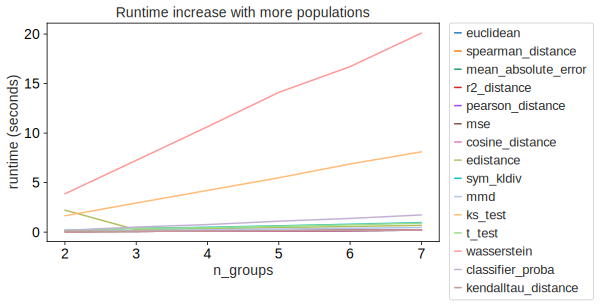

In [34]:
plot(durations, 'n_groups')
plt.title('Runtime increase with more populations')
plt.savefig('./figures/runtime.svg')

In [35]:
pd.DataFrame(durations).to_csv('./figures/runtime.csv')